<a href="https://colab.research.google.com/github/ShreyanshJoshi/Temp/blob/master/Attempt_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The original work consumed face pictures collected from IMDB (7 GB) and Wikipedia (1 GB).In this implementation, we use Wikipedia (1 GB) dataset.
The dataset has been zipped and uploaded into Google Drive, which in turn has been mounted onto Google Colab

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip "/content/drive/My Drive/Colab Notebooks/Age and Gender Detection from Faces/Attempt 1 - Transfer Learning/wiki_crop.zip"                    # Unzipping the zip file, so that it can be referred to by code

Streaming output truncated to the last 5000 lines.
  inflating: wiki_crop/93/1020893_1945-04-29_1968.jpg  
  inflating: wiki_crop/93/1021093_1973-01-17_2008.jpg  
  inflating: wiki_crop/93/10281093_1939-12-30_2010.jpg  
  inflating: wiki_crop/93/3023093_1951-12-03_2006.jpg  
  inflating: wiki_crop/93/4024793_1944-09-19_1977.jpg  
  inflating: wiki_crop/93/11219693_1983-04-19_2005.jpg  
  inflating: wiki_crop/93/11225193_1982-07-05_2009.jpg  
  inflating: wiki_crop/93/11282893_1969-03-20_2015.jpg  
  inflating: wiki_crop/93/11294993_1983-09-27_2012.jpg  
  inflating: wiki_crop/93/2122293_1957-04-24_2014.jpg  
  inflating: wiki_crop/93/2126093_1985-06-19_2010.jpg  
  inflating: wiki_crop/93/31225793_1960-02-02_2009.jpg  
  inflating: wiki_crop/93/31254793_1953-09-28_2011.jpg  
  inflating: wiki_crop/93/412193_1895-08-13_1940.jpg  
  inflating: wiki_crop/93/412993_1930-12-17_1993.jpg  
  inflating: wiki_crop/93/7126493_1968-12-30_2006.jpg  
  inflating: wiki_crop/93/12272693_1929-08-27_20

In [0]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import applications,activations
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras import optimizers,utils
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D
from keras.layers import Convolution2D, Activation,MaxPooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

Using TensorFlow backend.


In [0]:
mat = scipy.io.loadmat('wiki_crop/wiki.mat')
# Reading Matlab files with SciPy

In [0]:
# Converting into pandas dataframe. Always easier and better to deal with :)

instances = mat['wiki'][0][0][0].shape[1]
 
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]
 
df = pd.DataFrame(index = range(0,instances), columns = columns)
 
for i in mat:
    if i == "wiki":
        current_array = mat[i][0][0]
        
for j in range(len(current_array)):
    df[columns[j]] = pd.DataFrame(current_array[j][0])

In [0]:
df.head()               # Lets see how exactly our dataset looks

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,[Sami Jauhojärvi],"[[111.29109473290997, 111.29109473290997, 252....",4.300962,NaN
1,703186,1964,[48/10000548_1925-04-04_1964.jpg],1.0,[Dettmar Cramer],"[[252.48330229530742, 126.68165114765371, 354....",2.645639,1.949248
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,[Marc Okrand],"[[113.52, 169.83999999999997, 366.08, 422.4]]",4.329329,NaN
3,705061,1961,[65/10001965_1930-05-23_1961.jpg],1.0,[Aleksandar Matanović],"[[1, 1, 634, 440]]",-inf,NaN
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,[Diana Damrau],"[[171.61031405173117, 75.57451239763239, 266.7...",3.408442,NaN


Converting DOB to Python format. We just need the birth year.

PS: I copy-pasted this code :P

In [0]:
from datetime import datetime, timedelta
def datenum_to_datetime(datenum):
    days = datenum % 1
    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    exact_date = datetime.fromordinal(int(datenum)) \
    + timedelta(days=int(days)) + timedelta(hours=int(hours)) \
    + timedelta(minutes=int(minutes)) + timedelta(seconds=round(seconds)) \
    - timedelta(days=366)

    return exact_date.year
 
df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)

In [0]:
df['age'] = df['photo_taken'] - df['date_of_birth']          # Getting present age

In [0]:
#remove pictures does not include face
df = df[df['face_score'] != -np.inf]
 
#some pictures include more than one face, remove them
df = df[df['second_face_score'].isna()]
 
#check threshold
df = df[df['face_score'] >= 3]
 
#some records do not have a gender information
df = df[~df['gender'].isna()]
 
df = df.drop(columns = ['name','face_score','second_face_score','date_of_birth','face_location'])

#some guys seem to be greater than 100. some of these are paintings. remove these old guys
df = df[df['age'] <= 100]
 
#some guys seem to be unborn in the data set
df = df[df['age'] > 0]

In [0]:
df.head()

,dob,photo_taken,full_path,gender,age
0,723671,2009,[17/10000217_1981-05-05_2009.jpg],1.0,28
2,711677,2008,[12/100012_1948-07-03_2008.jpg],1.0,60
4,720044,2012,[16/10002116_1971-05-31_2012.jpg],0.0,41
5,716189,2012,[02/10002702_1960-11-09_2012.jpg],0.0,52
6,707745,1971,[41/10003541_1937-09-27_1971.jpg],1.0,34


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22138 entries, 0 to 62327
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dob          22138 non-null  int32  
 1   photo_taken  22138 non-null  uint16 
 2   full_path    22138 non-null  object 
 3   gender       22138 non-null  float64
 4   age          22138 non-null  int64  
dtypes: float64(1), int32(1), int64(1), object(1), uint16(1)
memory usage: 821.5+ KB


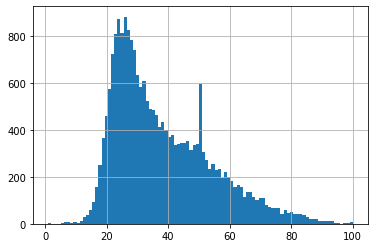

In [0]:
histogram_age = df['age'].hist(bins=df['age'].nunique())            

# Pretty obvious that a large chunk of population in training data is from 20 to 60


In [0]:
 df = df[::6]                    
 ''' Step size is 6. Actually there are 22138 entries in dataframe. But for computational reasons, i choose every 6th entry. 
 Google colab has limited RAM (12 GB) and gets exhausted for any larger dataframe. Needless to say, running image dataset 
 on local machine is not a good idea !''' 

' Step size is 6. Actually there are 22138 entries in dataframe. But for computational reasons, i choose every 6th entry. \nGoogle colab has limited RAM (12 GB) and gets exhausted for any larger dataframe. Needless to say, running image dataset \non local machine is not a good idea !'

In [0]:
# Full path column states the exact location of the picture on the disk.We need its pixel values.

target_size = (224, 224)
 
def getImagePixels(image_path):
    img = load_img("wiki_crop/%s" % image_path[0], grayscale=False, target_size=target_size)
    x = img_to_array(img).reshape(1, -1)[0]
    return x
 
df['pixels'] = df['full_path'].apply(getImagePixels)

In [0]:
classes = 101                                                # 0 to 100
target = df['age'].values
target_classes = utils.to_categorical(target, classes)
 
features = []
 
for i in range(0, df.shape[0]):
  features.append(df['pixels'].values[i])
 
features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)

# Splitting dataset as training and testing set. Essentially, here test set is basically
# validation set. Actual test set is on what we apply model in real life (and is with 
# competition organizers in case of a competition)

from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(features, target_classes, test_size=0.30)


# APPARENT  AGE   PREDICTION   MODEL
Age prediction is a regression problem. But researchers define it as a classification problem. There are 101 classes in the output layer for ages 0 to 100. We apply transfer learning to exploit the closeness of this task with facial processing tasks. 

In [0]:
'''VGG-Face model'''

model = Sequential()
# Remember it is VGG (transfer learning). Hence the input shape
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))                    
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))
model.load_weights('/content/drive/My Drive/Colab Notebooks/Age and Gender Detection from Faces/Attempt 1 - Transfer Learning/vgg_face_weights.h5')

In [0]:
for layer in model.layers[:-7]:
  layer.trainable = False
 
 # We should lock the layer weights for early layers because they could already detect some patterns. 
 # Since, we need 101 (0-100) units for age prediction,
 #  we add a custom convolution layer consisting of 101 units.

base_model_output = Sequential()
base_model_output = Convolution2D(101, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)
 
age_model = Model(inputs=model.input, outputs=base_model_output)

In [0]:
age_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_14_input (Inp (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 114, 114, 64)      0   

In [0]:
age_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])
 
checkpointer = ModelCheckpoint(filepath='age_model.hdf5'
, monitor = "val_loss", verbose=1, save_best_only=True, mode = 'auto')
 
scores = []
epochs = 5; batch_size = 256
 
for i in range(epochs):
  print("epoch ",i)
 
  ix_train = np.random.choice(train_x.shape[0], size=batch_size)
  
  score = age_model.fit(train_x[ix_train], train_y[ix_train]
  , epochs=1, validation_data=(test_x, test_y), callbacks=[checkpointer])
  
  scores.append(score)

epoch  0
Train on 256 samples, validate on 1107 samples
Epoch 1/1
256/256 [==============================] - 22s 87ms/step - loss: 12.5079 - accuracy: 0.0273 - val_loss: 5.3178 - val_accuracy: 0.0280

Epoch 00001: val_loss improved from inf to 5.31783, saving model to age_model.hdf5
epoch  1
Train on 256 samples, validate on 1107 samples
Epoch 1/1
256/256 [==============================] - 10s 40ms/step - loss: 7.4252 - accuracy: 0.0117 - val_loss: 4.6050 - val_accuracy: 0.0181

Epoch 00001: val_loss improved from 5.31783 to 4.60498, saving model to age_model.hdf5
epoch  2
Train on 256 samples, validate on 1107 samples
Epoch 1/1
256/256 [==============================] - 10s 40ms/step - loss: 5.5849 - accuracy: 0.0195 - val_loss: 4.6053 - val_accuracy: 0.0172

Epoch 00001: val_loss did not improve from 4.60498
epoch  3
Train on 256 samples, validate on 1107 samples
Epoch 1/1
256/256 [==============================] - 10s 40ms/step - loss: 5.4229 - accuracy: 0.0312 - val_loss: 4.5988 - 

In [0]:
 # Final testing of model (to see  how model performs on unseen data - albeit this data is 
 # from the same distribution as training set. So, if model performs poorly on it, we 
 # can conclude that model is overfitting)
age_model.evaluate(test_x, test_y, verbose=1)  

# Output of form - (loss, accuracy)

1107/1107 [==============================] - 8s 7ms/step


[4.5974335368948145, 0.016260161995887756]

In [0]:
predictions = age_model.predict(test_x)          # Getting the predictions


In [0]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
 
def loadImage(filepath):
  test_img = image.load_img(filepath, target_size=(224, 224))
  test_img = image.img_to_array(test_img)
  test_img = np.expand_dims(test_img, axis = 0)
  test_img /= 255
  return test_img

 # This picture should be in the same directory from which the nb is running
picture = "/content/drive/My Drive/IMG_20190608_161229.jpg"                                     
prediction = age_model.predict(loadImage(picture))
max = -1
for i in range(101):
    if prediction[0][i]>max:
      max = prediction[0][i];
      temp  = i
print(temp)
# Prediction variable stores distribution for each age class

## Testing Model on custom images

# GENDER  PREDICTION  MODEL

Gender Prediction is much easier than age prediction, primarily because it has less classes and gender related features are probably easier to learn

In [0]:
target = df['gender'].values
target_classes = utils.to_categorical(target, 2)                      #  Apply OHE to gender class
train_x, test_x, train_y, test_y = train_test_split(features, target_classes, test_size=0.30)

for layer in model.layers[:-7]:
  layer.trainable = False
 
base_model_output = Sequential()
base_model_output = Convolution2D(2, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)
 
gender_model = Model(inputs=model.input, outputs=base_model_output)

In [0]:
gender_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_14_input (Inp (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 114, 114, 64)      0   

In [0]:
scores = []
epochs = 40; batch_size = 128
gender_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])

for i in range(epochs):
  print("epoch ",i)
 
  ix_train = np.random.choice(train_x.shape[0], size=batch_size)
  
  score = gender_model.fit(train_x[ix_train], train_y[ix_train]
  , epochs=1, validation_data=(test_x, test_y), callbacks=[checkpointer])
  
  scores.append(score)

epoch  0
Train on 128 samples, validate on 1107 samples
Epoch 1/1
128/128 [==============================] - 9s 73ms/step - loss: 2.4228 - accuracy: 0.8594 - val_loss: 0.6219 - val_accuracy: 0.9476

Epoch 00001: val_loss did not improve from 0.17726
epoch  1
Train on 128 samples, validate on 1107 samples
Epoch 1/1
128/128 [==============================] - 9s 72ms/step - loss: 0.1567 - accuracy: 0.9609 - val_loss: 0.8556 - val_accuracy: 0.9512

Epoch 00001: val_loss did not improve from 0.17726
epoch  2
Train on 128 samples, validate on 1107 samples
Epoch 1/1
128/128 [==============================] - 9s 72ms/step - loss: 0.5878 - accuracy: 0.9531 - val_loss: 1.1116 - val_accuracy: 0.9521

Epoch 00001: val_loss did not improve from 0.17726
epoch  3
Train on 128 samples, validate on 1107 samples
Epoch 1/1
128/128 [==============================] - 9s 71ms/step - loss: 1.4181 - accuracy: 0.9531 - val_loss: 1.0773 - val_accuracy: 0.9530

Epoch 00001: val_loss did not improve from 0.17726


In [0]:

print(train_x.shape)
print(train_y.shape)

(256,)
(3099, 224, 224, 3)
(3099, 101)


In [0]:
gender_model.evaluate(test_x, test_y, verbose=1)                  # Evaluating on test set

1107/1107 [==============================] - 8s 7ms/step


[2.9486172206083805, 0.9548328518867493]

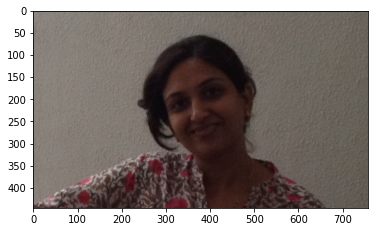

gender:  Female


In [0]:
 # This picture should be in the same directory from which the nb is running
picture = "/content/drive/My Drive/Colab Notebooks/Age and Gender Detection from Faces/Attempt 1 - Transfer Learning/Some Testing images/IMG_1051.JPG"                            
prediction = gender_model.predict(loadImage(picture))
 
img = image.load_img(picture)                          # target_size=(224, 224))
plt.imshow(img)
plt.show()
gender = "Male" if np.argmax(prediction) == 1 else "Female"
print("gender: ", gender)